In [348]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [349]:
# The problem we are trying to solve is to group similar minded customers together
offers_df = pd.read_excel("WineKMC.xlsx", sheet_name=0)
offers_df.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [350]:
offers_df.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
offers_df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [351]:
offers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
offer_id     32 non-null int64
campaign     32 non-null object
varietal     32 non-null object
min_qty      32 non-null int64
discount     32 non-null int64
origin       32 non-null object
past_peak    32 non-null bool
dtypes: bool(1), int64(3), object(3)
memory usage: 1.6+ KB


In [352]:
transactions_df = pd.read_excel("WineKMC.xlsx", sheet_name=1)
transactions_df.head()

,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [353]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
Customer Last Name    324 non-null object
Offer #               324 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.1+ KB


In [354]:
transactions_df.columns = ["customer_name", "offer_id"]
transactions_df.head()

,customer_name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [355]:
transactions_df['n'] = 1
transactions_df.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [356]:
# We want to group similar minded customers together
# Creating a data frame where each row has the following columns:
# customer_name
# One column for each offer, with a 1 if the customer responded to the offer
# Verifying that offer_id is not having any null values
print(transactions_df.offer_id.isnull().any())
print(offers_df.offer_id.isnull().any())

False
False


In [357]:
# Merging
merged_df = offers_df.merge(transactions_df, how='inner')[['offer_id', 'customer_name', 'n']]
merged_df.head()

,offer_id,customer_name,n
0,1,Thomas,1
1,1,Jackson,1
2,1,Mitchell,1
3,1,Peterson,1
4,1,Wood,1


In [358]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 3 columns):
offer_id         324 non-null int64
customer_name    324 non-null object
n                324 non-null int64
dtypes: int64(2), object(1)
memory usage: 10.1+ KB


In [359]:
# Pivoting
pivot_merged_df = merged_df.pivot("customer_name", "offer_id", "n")
pivot_merged_df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [360]:
# Filling in the null values and making customer name a column
# 0/1 value indicates that whether the customer reponded to the offer or not
behavior_df = pivot_merged_df.fillna(0).reset_index()
behavior_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [361]:
behavior_df.loc[0]

offer_id
customer_name    Adams
1                    0
2                    0
3                    0
4                    0
5                    0
6                    0
7                    0
8                    0
9                    0
10                   0
11                   0
12                   0
13                   0
14                   0
15                   0
16                   0
17                   0
18                   1
19                   0
20                   0
21                   0
22                   0
23                   0
24                   0
25                   0
26                   0
27                   0
28                   0
29                   1
30                   1
31                   0
32                   0
Name: 0, dtype: object

In [362]:
behavior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 33 columns):
customer_name    100 non-null object
1                100 non-null float64
2                100 non-null float64
3                100 non-null float64
4                100 non-null float64
5                100 non-null float64
6                100 non-null float64
7                100 non-null float64
8                100 non-null float64
9                100 non-null float64
10               100 non-null float64
11               100 non-null float64
12               100 non-null float64
13               100 non-null float64
14               100 non-null float64
15               100 non-null float64
16               100 non-null float64
17               100 non-null float64
18               100 non-null float64
19               100 non-null float64
20               100 non-null float64
21               100 non-null float64
22               100 non-null float64
23               100 no

In [363]:
# K-means clustering
# Choosing K: The Elbow Sum-Of-Squares method
# Creating a numpy matrix with only the columns representing the offers (i.e. the 0/1 columns)
x_cols = behavior_df.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

In [364]:
type(x_cols)

pandas.core.indexes.base.Index

In [365]:
model = KMeans()
inertias = []
sse = {}
kmeans_elbow_df = behavior_df.copy()

In [366]:
parameters = {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
parameter_grid = ParameterGrid(parameters)

In [367]:
for g in parameter_grid:
    k = g['n_clusters']
    sse[k] = 0
    model.set_params(**g)
    # Saving the value of sum of squared error
    kmeans_elbow_df['cluster'] = model.fit_predict(behavior_df[x_cols])
    sample_value = []
    for index, row in kmeans_elbow_df.iterrows():
        sample_value.clear()
        for i in range(1, 33):
            sample_value.append(row[i])
        mse = mean_squared_error(sample_value, model.cluster_centers_[row['cluster']])
        sse[k] += mse;
    # Saving the value of inertia
    inertias.append(model.inertia_)    

In [368]:
kmeans_elbow_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,7
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3


In [369]:
for item in inertias:
    print(item)

251.46031746031744
228.33622881355933
213.8773291925466
205.18942577030813
194.56193693693695
187.1283127767236
179.0534090909091
175.05059523809524
166.53055555555557


In [370]:
for item in sse.items():
    print(item)

(2, 7.858134920634921)
(3, 7.13550715042373)
(4, 6.683666537267082)
(5, 6.412169555322128)
(6, 6.08006052927928)
(7, 5.847759774272611)
(8, 5.595419034090909)
(9, 5.470331101190475)
(10, 5.204079861111111)


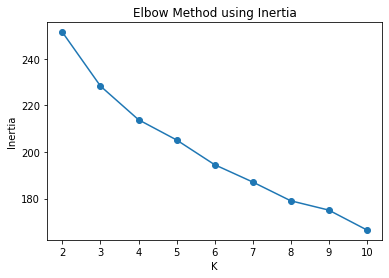

In [371]:
# Plotting inertia as a funtion of k
plt.plot(parameters['n_clusters'], inertias, marker='o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title('Elbow Method using Inertia')
plt.show()

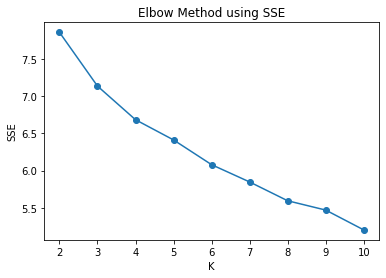

In [372]:
# Plotting sse as a function of k
sorted_sse = sorted(sse.items())
x, y = zip(*sorted_sse)
plt.plot(x, y, marker='o')
plt.xlabel("K")
plt.ylabel("SSE")
plt.title('Elbow Method using SSE')
plt.show()

In [373]:
# Choosing K: The Silhouette Method
best_score = -1
model = KMeans()

In [374]:
for g in parameter_grid:
    model.set_params(**g)
    model.fit(behavior_df[x_cols])
    ss = silhouette_score(behavior_df[x_cols], model.labels_)
    print('Parameter: ', g, 'Score: ', ss)
    if ss > best_score:
        best_score = ss
        best_grid = g

Parameter:  {'n_clusters': 2} Score:  0.09174871508750351
Parameter:  {'n_clusters': 3} Score:  0.11806755362739517
Parameter:  {'n_clusters': 4} Score:  0.1293361985869671
Parameter:  {'n_clusters': 5} Score:  0.10993137909857623
Parameter:  {'n_clusters': 6} Score:  0.09763004581905368
Parameter:  {'n_clusters': 7} Score:  0.12486335623572288
Parameter:  {'n_clusters': 8} Score:  0.1244958801480185
Parameter:  {'n_clusters': 9} Score:  0.1317069637137051
Parameter:  {'n_clusters': 10} Score:  0.11029583877535307


In [375]:
best_grid

{'n_clusters': 9}

In [376]:
cluster = KMeans(n_clusters=5)
kmeans_behavior_df = behavior_df.copy()
kmeans_behavior_df['cluster'] = cluster.fit_predict(kmeans_behavior_df[x_cols])
kmeans_behavior_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [377]:
kmeans_behavior_df.cluster.value_counts()

2    34
1    27
3    15
0    15
4     9
Name: cluster, dtype: int64

In [378]:
# Visualization
pca = PCA(n_components=2)
kmeans_behavior_df['x'] = pca.fit_transform(kmeans_behavior_df[x_cols])[:,0]
kmeans_behavior_df['y'] = pca.fit_transform(kmeans_behavior_df[x_cols])[:,1]
kmeans_behavior_df.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,cluster,x,y
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2,1.007580,0.108215
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,-0.287539,0.044715
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,-0.392032,1.038391
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,0.699477,-0.022542
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.088183,-0.471695


In [379]:
customer_clusters = kmeans_behavior_df[['customer_name', 'cluster', 'x', 'y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,2,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,3,-0.392032,1.038391
3,Bailey,2,0.699477,-0.022542
4,Baker,0,0.088183,-0.471695


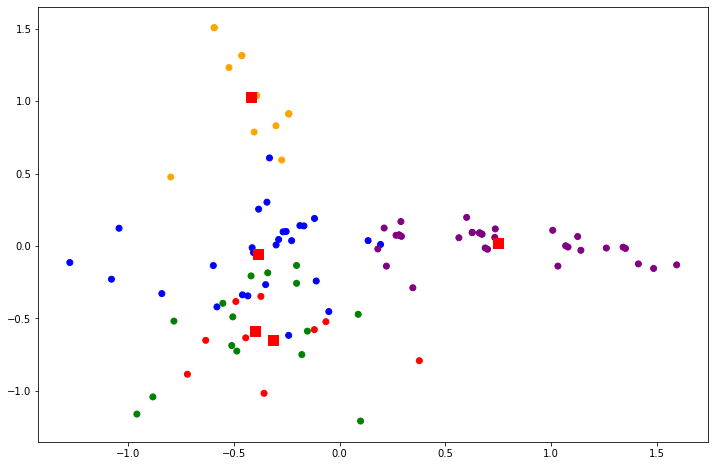

In [380]:
colors = ['green', 'blue', 'purple', 'orange', 'red']
plt.figure(figsize=(12, 8))
plt.scatter(customer_clusters['x'], customer_clusters['y'], c=customer_clusters['cluster'], 
           cmap=matplotlib.colors.ListedColormap(colors))
centroids = pca.transform(cluster.cluster_centers_)
centroids = pd.DataFrame(centroids, columns=['x', 'y'])
plt.scatter(centroids['x'], centroids['y'], c='r', s=100, marker='s')

In [381]:
# Affinity Propogation
affinity_propogation_model = AffinityPropagation(damping=0.6, max_iter=1000).fit(behavior_df[x_cols])
print(silhouette_score(behavior_df[x_cols], affinity_propogation_model.labels_))

0.12346523604478911


In [382]:
# Spectral Clustering
spectral_clustering_model = SpectralClustering(n_clusters=3).fit(behavior_df[x_cols])
print(silhouette_score(behavior_df[x_cols], spectral_clustering_model.labels_))

0.10611539040197304


In [383]:
# Agglomerative Clustering
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=3).fit(behavior_df[x_cols])
print(silhouette_score(behavior_df[x_cols], agglomerative_clustering_model.labels_))

0.11625878863607858


In [385]:
# DBSCAN
dbscan_model = DBSCAN(eps=0.45, min_samples=4).fit(behavior_df[x_cols])